## Importing necessary libraries

In [ ]:
import tensorflow as tf
import numpy as np
import re, os
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

## Getting data from Kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d columbine/imdb-dataset-sentiment-analysis-in-csv-format
!unzip '/content/imdb-dataset-sentiment-analysis-in-csv-format.zip'

 97% 25.0M/25.7M [00:00<00:00, 9.53MB/s]
100% 25.7M/25.7M [00:00<00:00, 27.9MB/s]
Archive:  /content/imdb-dataset-sentiment-analysis-in-csv-format.zip
  inflating: Test.csv                
  inflating: Train.csv               
  inflating: Valid.csv               


In [ ]:
df_train = pd.read_csv('/content/Train.csv')
df_train.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [ ]:
df_val = pd.read_csv('/content/Valid.csv')
df_val.head()

,text,label
0,It's been about 14 years since Sharon Stone aw...,0
1,someone needed to make a car payment... this i...,0
2,The Guidelines state that a comment must conta...,0
3,This movie is a muddled mish-mash of clichés f...,0
4,Before Stan Laurel became the smaller half of ...,0


In [ ]:
df_test = pd.read_csv('/content/Test.csv')
df_test.head()

,text,label
0,I always wrote this series off as being a comp...,0
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,0
2,This movie was so poorly written and directed ...,0
3,The most interesting thing about Miryang (Secr...,1
4,"when i first read about ""berlin am meer"" i did...",0


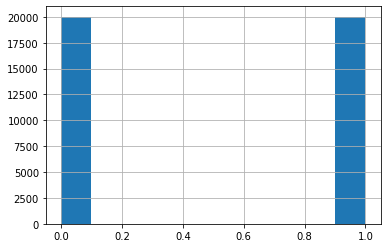

In [ ]:
df_train['label'].hist()

In [ ]:
# Pretty equally split

df_train['label'].value_counts()

0    20019
1    19981
Name: label, dtype: int64

## Preprocessing

In [ ]:
# Cleaning/Preprocessing Helper function 

def preprocess(s):
  s = re.sub(r'@[a-zA-Z0-9_.]+ ', '', str(s))
  s = re.sub(r'#[a-zA-Z0-9_.]+ ', '', str(s))
  s = re.sub(r'''[^a-zA-Z0-9?. ]+''', '', s)
  s = re.sub(r''''[' ']+''', " ", s)
  s = re.sub(r'(\w)\1{2,}',r'\1',s)
  s = s.lower().strip()
  return s

In [ ]:
df_train['text'] = df_train['text'].apply(preprocess)
df_val['text'] = df_val['text'].apply(preprocess)
df_test['text'] = df_test['text'].apply(preprocess)

In [ ]:
# Splitting one and zero values for custom sampling
zeros, ones = df_train[df_train['label']==0], df_train[df_train['label']==1]
zeros_val, ones_val = df_val[df_val['label']==0], df_val[df_val['label']==1]
zeros_test, ones_test = df_test[df_test['label']==0], df_test[df_test['label']==1]
len(zeros), len(ones), type(zeros)

(20019, 19981, pandas.core.frame.DataFrame)

In [ ]:
# Extracting data as numpy arrays
zero_text, zero_labels = zeros['text'].to_numpy(), zeros['label'].to_numpy() 
one_text, one_labels = ones['text'].to_numpy(), ones['label'].to_numpy()

zero_val_text, zero_val_labels = zeros_val['text'].to_numpy(), zeros_val['label'].to_numpy() 
one_val_text, one_val_labels = ones_val['text'].to_numpy(), ones_val['label'].to_numpy()

zero_test_text, zero_test_labels = zeros_test['text'].to_numpy(), zeros_test['label'].to_numpy() 
one_test_text, one_test_labels = ones_test['text'].to_numpy(), ones_test['label'].to_numpy()

In [ ]:
# Sampling the training, testing and validation sets
X_train, Y_train = np.concatenate((one_text,zero_text)), np.concatenate((one_labels,zero_labels))
X_val, Y_val = np.concatenate((one_val_text,zero_val_text)), np.concatenate((one_val_labels,zero_val_labels))
X_test, Y_test = np.concatenate((one_test_text,zero_test_text)), np.concatenate((one_test_labels,zero_test_labels))

In [ ]:
# Instantiating the Tokenizer and creating sequences
tokenizer = tf.keras.preprocessing.text.Tokenizer(3000,oov_token=1)
tokenizer.fit_on_texts(X_train)
train_seq = tokenizer.texts_to_sequences(X_train)
val_seq = tokenizer.texts_to_sequences(X_val)
test_seq = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Padding all sequences
train_seq = tf.keras.preprocessing.sequence.pad_sequences(train_seq,maxlen=50,padding='post')
val_seq = tf.keras.preprocessing.sequence.pad_sequences(val_seq,maxlen=50,padding='post')
test_seq = tf.keras.preprocessing.sequence.pad_sequences(test_seq,maxlen=50,padding='post')

## Creating the Model

In [ ]:
from tensorflow.keras.layers import Embedding,Dense,LSTM,Flatten,Dropout
def create_model():
  model = tf.keras.models.Sequential()
  model.add(Embedding(3000,64))
  model.add(LSTM(32))
  model.add(Flatten())
  model.add(Dense(64,activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(32,activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(8,activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(4,activation='relu'))
  model.add(Dense(1,activation='sigmoid'))
  model.summary()
  model.compile(optimizer=tf.keras.optimizers.Adam(0.0005),loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])
  return model

## FULL MODEL TRAINING

In [ ]:
# HELPER FUNCTION

def plot(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['train_loss','val_loss'])
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.legend(['train_accuracy','val_accuracy'])
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()

In [ ]:
def train_full_model(train_seq,Y_train,val_seq,Y_val,test_seq,Y_test):
  model = create_model()
  history = model.fit(train_seq,Y_train,256,15,validation_data=(val_seq,Y_val),callbacks=[tf.keras.callbacks.ModelCheckpoint('FullModelCheckpoint.h5',save_best_only=True,verbose=1),tf.keras.callbacks.EarlyStopping(patience=6,verbose=1)])
  plot(history)
  model = tf.keras.models.load_model('FullModelCheckpoint.h5')
  print(model.evaluate(test_seq,Y_test))
  return model

## ACTIVE LEARNING

In [ ]:
# HELPER FUNCTIONS

def append_history(losses,val_losses,acc,val_acc,history):
  losses = losses + history.history['loss']
  val_losses = val_losses + history.history['val_loss']
  acc = acc + history.history['accuracy']
  val_acc = val_acc + history.history['val_accuracy']
  return losses,val_losses,acc,val_acc

def plot_merged_metrics(losses,val_losses,accuracies,val_accuracies):
  plt.plot(losses)
  plt.plot(val_losses)
  plt.legend(['train_loss','val_loss'])
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

  plt.plot(accuracies)
  plt.plot(val_accuracies)
  plt.legend(['train_accuracy','val_accuracy'])
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()

In [ ]:
def train_small_models(train_features,train_labels,oracle_features1,oracle_labels1,oracle_features2,oracle_labels2,val_seq,Y_val,test_seq,Y_test):

  losses, val_losses, accuracies, val_accuracies = [], [], [], []

  model = create_model()
  checkpoint = tf.keras.callbacks.ModelCheckpoint('Checkpoint.h5',save_best_only=True,verbose=1)
  history = model.fit(train_features,train_labels,256,15,validation_data=(val_seq,Y_val),callbacks=[checkpoint,tf.keras.callbacks.EarlyStopping(patience=6,verbose=1)])
  losses, val_losses, accuracies, val_accuracies = append_history(losses,val_losses,accuracies,val_accuracies,history) 
  model = tf.keras.models.load_model('Checkpoint.h5')

  for iter_n, i in enumerate([(oracle_features1,oracle_labels1),(oracle_features2,oracle_labels2)]):
    # Getting predictions from previously trained model
    predictions = model.predict(i[0])

    # Get all inconfident predictions. We set the threshold of inconfidence to all values < 90%
    inconfident_preds = np.where(np.max(predictions,axis=1)<0.9)[0]

    # Get all incorrect predictions
    wrong_preds = np.where(np.not_equal(predictions,i[1]))

    # Combine and get all unique indices
    unique = list(set(np.append(inconfident_preds,wrong_preds[0])))


    # Sampling only required indices from the "unlabelled" pool
    update_f = i[0][unique]
    update_l = i[1][unique]

    # Add the sampled entries to the original data
    train_features = np.concatenate((train_features,update_f),axis=0)
    train_labels = np.concatenate((train_labels,update_l),axis=0)

    # Retrain the model with inconfident and incorrect predictions only
    history = model.fit(train_features,train_labels,validation_data=(val_seq,Y_val),epochs=15,batch_size=256,callbacks=[checkpoint,tf.keras.callbacks.EarlyStopping(patience=6,verbose=1)])
    
    losses, val_losses, accuracies, val_accuracies = append_history(losses,val_losses,accuracies,val_accuracies,history) 

    model = tf.keras.models.load_model('Checkpoint.h5')
    print(model.evaluate(test_seq,Y_test))

  plot_merged_metrics(losses,val_losses,accuracies,val_accuracies)
  
  return model  

## ENSEMBLING

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 64)          192000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                12416     
_________________________________________________________________
flatten_4 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_13 (Dropout)         (None, 32)               

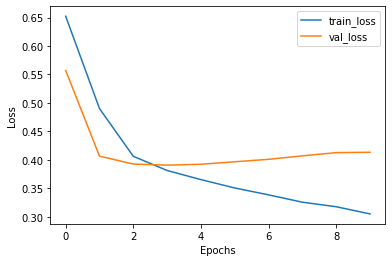

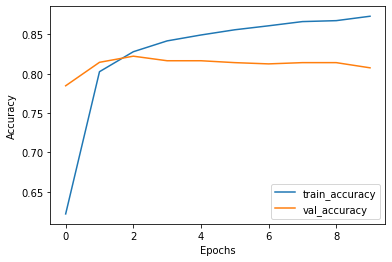

157/157 [==============================] - 1s 6ms/step - loss: 0.3911 - accuracy: 0.8234
[0.3911040425300598, 0.8234000205993652]
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 64)          192000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                12416     
_________________________________________________________________
flatten_5 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 32)                2

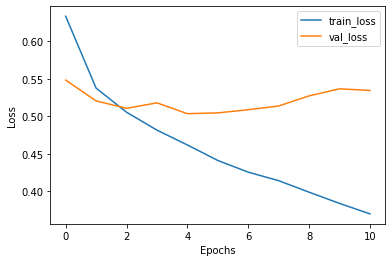

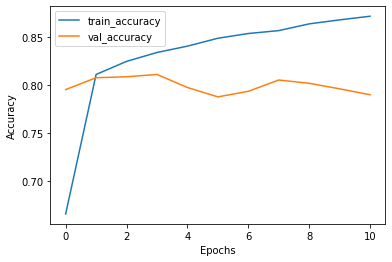

157/157 [==============================] - 1s 6ms/step - loss: 0.4998 - accuracy: 0.7996
[0.4997769892215729, 0.7996000051498413]
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 64)          192000    
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                12416     
_________________________________________________________________
flatten_6 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_18 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 32)                2

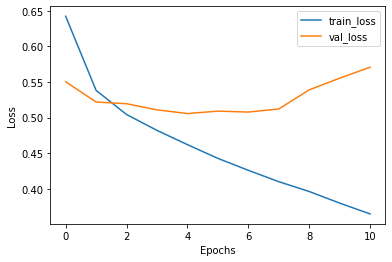

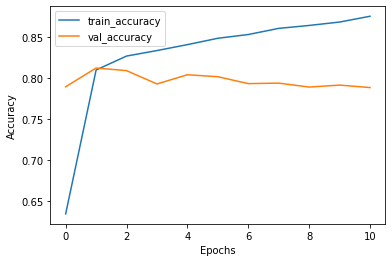

157/157 [==============================] - 1s 5ms/step - loss: 0.5042 - accuracy: 0.8042
[0.5042011141777039, 0.8041999936103821]


In [ ]:
model1 = train_full_model(train_seq,Y_train,val_seq,Y_val,test_seq,Y_test)
model2 = train_full_model(train_seq,Y_train,val_seq,Y_val,test_seq,Y_test)
model3 = train_full_model(train_seq,Y_train,val_seq,Y_val,test_seq,Y_test)

In [ ]:
# Splitting Data into Oracle Set(Unlabelled set) and Original Training set 
import sklearn.model_selection
train_features,X_tt,train_labels,Y_tt = sklearn.model_selection.train_test_split(train_seq,Y_train,test_size=0.1,stratify=Y_train)
oracle_features1,oracle_features2,oracle_labels1,oracle_labels2 = sklearn.model_selection.train_test_split(X_tt,Y_tt,test_size=0.5,stratify=Y_tt)
train_features.shape,oracle_features1.shape,oracle_features2.shape

((36000, 50), (2000, 50), (2000, 50))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 64)          192000    
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                12416     
_________________________________________________________________
flatten_7 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_21 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_22 (Dropout)         (None, 32)               

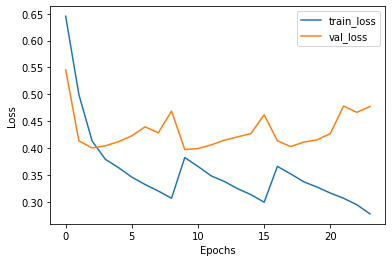

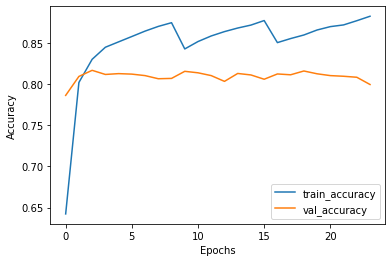

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 64)          192000    
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                12416     
_________________________________________________________________
flatten_8 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_24 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_25 (Dropout)         (None, 32)               

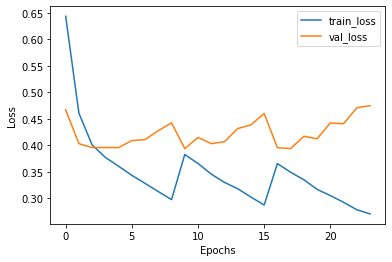

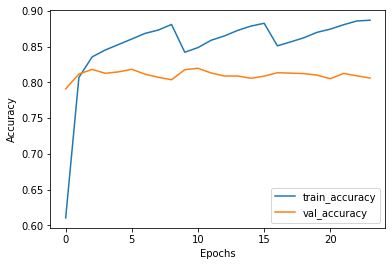

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 64)          192000    
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                12416     
_________________________________________________________________
flatten_9 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_27 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_28 (Dropout)         (None, 32)               

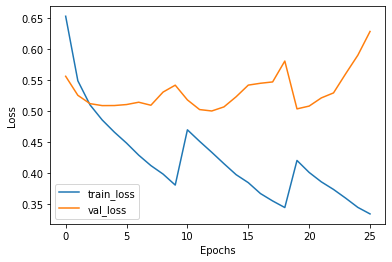

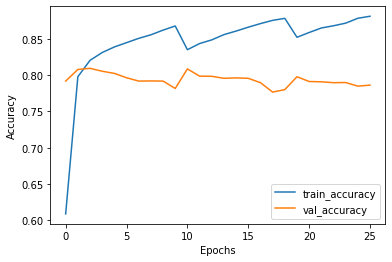

In [ ]:
al_model1 = train_small_models(train_features,train_labels,oracle_features1,oracle_labels1,oracle_features2,oracle_labels2,val_seq,Y_val,test_seq,Y_test)
al_model2 = train_small_models(train_features,train_labels,oracle_features1,oracle_labels1,oracle_features2,oracle_labels2,val_seq,Y_val,test_seq,Y_test)
al_model3 = train_small_models(train_features,train_labels,oracle_features1,oracle_labels1,oracle_features2,oracle_labels2,val_seq,Y_val,test_seq,Y_test)

PREDICTIONS

In [ ]:
# Ensembling by taking elementwise average

pred = (model1.predict(test_seq)+model2.predict(test_seq)+model3.predict(test_seq))/3
al_pred = (al_model1.predict(test_seq)+al_model2.predict(test_seq)+al_model3.predict(test_seq))/3

In [ ]:
pred = np.where(pred<0.5,0,1)
al_pred = np.where(al_pred<0.5,0,1)
print(pred[:5],al_pred[:5])

[[1]
 [1]
 [0]
 [0]
 [1]] [[1]
 [1]
 [0]
 [1]
 [0]]


In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(pred,Y_test))
print(accuracy_score(al_pred,Y_test))

0.8148
0.8234


In [ ]:
model1.evaluate(test_seq,Y_test),model2.evaluate(test_seq,Y_test),model3.evaluate(test_seq,Y_test)

157/157 [==============================] - 1s 6ms/step - loss: 0.5042 - accuracy: 0.8042


([0.3911040425300598, 0.8234000205993652],
 [0.4997769892215729, 0.7996000051498413],
 [0.5042011141777039, 0.8041999936103821])

In [ ]:
al_model1.evaluate(test_seq,Y_test),al_model2.evaluate(test_seq,Y_test),al_model3.evaluate(test_seq,Y_test)

157/157 [==============================] - 1s 6ms/step - loss: 0.5049 - accuracy: 0.7936


([0.39213627576828003, 0.8163999915122986],
 [0.38961705565452576, 0.8220000267028809],
 [0.5049449801445007, 0.7936000227928162])